## DataSet

In [ ]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, utils
from torch.autograd import Variable

import os
import csv
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
%matplotlib inline
# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

%load_ext autoreload

%autoreload 2
plt.ion()   # interactive mode



from torch.nn import Conv2d as Conv2D
import torch.nn.init as init
import torch.nn.functional as F
from torch.nn import Upsample

import cv2
from torch.utils.data import Dataset

In [1]:
# The data might not e available now, This code is for Jan, 2021
!gdown --id 1opMhHAiMJVdD0eYAJEcuHZgTscgFBCpj
!gdown --id 1uVs0yvi-HRj0yyez9MbnGwk_EsCHDLzl

/home/hamed/.local/lib/python3.8/site-packages/gdown/cli.py:127: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Access denied with the following error:

 	Cannot retrieve the public link of the file. You may need to change
	the permission to 'Anyone with the link', or have had many accesses. 

You may still be able to access the file from the browser:

	 https://drive.google.com/uc?id=1opMhHAiMJVdD0eYAJEcuHZgTscgFBCpj 

/home/hamed/.local/lib/python3.8/site-packages/gdown/cli.py:127: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Access denied with the following error:

 	Cannot retrieve the public link of the file. You may need to change
	the permission to 'Anyone with the link', or have had many accesses. 

You may still be able to access the file from the browser:


In [ ]:
%mkdir Dataset
%mkdir Dataset/2d_images
%mkdir Dataset/2d_masks

mkdir: cannot create directory ‘Dataset’: File exists
mkdir: cannot create directory ‘Dataset/2d_images’: File exists
mkdir: cannot create directory ‘Dataset/2d_masks’: File exists


In [ ]:

!unzip -q 2d_images.zip.zip 
!unzip -q 2d_images.zip -d Dataset/2d_images

!unzip -q 2d_masks.zip.zip 
!unzip -q 2d_masks.zip -d Dataset/2d_masks

In [ ]:
!rm -rf 2d_images.zip.zip
!rm -rf 2d_images.zip

!rm -rf 2d_masks.zip.zip
!rm -rf 2d_masks.zip

## DataLoader

In [ ]:
class CT_Data(Dataset):

    def __init__(self, csv_file, root_dir):

        self.image_frame = pd.read_csv(csv_file, skiprows=1)
        self.root_dir = root_dir

    def __len__(self):
        return len(self.image_frame)

    def __getitem__(self, idx):

        img_name = os.path.join(self.root_dir, self.image_frame.iloc[idx, 0])
        mask_name = os.path.join(self.root_dir, self.image_frame.iloc[idx, 1])
        image = cv2.imread(img_name, 0)
        image = cv2.resize(image,(32, 32))
        image = image.reshape((1, 32, 32))
        mask = cv2.imread(mask_name, 0)
        mask = cv2.resize(mask, (32, 32))
        mask = mask.reshape((1, 32, 32))

        mask[mask >= 1] = 1

        sample = {'image': image, 'mask': mask}
        return sample

In [ ]:
img_dir = "Dataset/2d_images/"
msk_dir = "Dataset/2d_masks/"
with open('Dataset/Dataset.csv', 'w') as csv_file:
    writer = csv.writer(csv_file)
    writer.writerow(["filename", "mask"])
    for p in os.listdir(img_dir):
        image_path = os.path.join(img_dir, p)
        mask_path = os.path.join(msk_dir, p)
        writer.writerow([image_path, mask_path])


data = pd.read_csv("Dataset/Dataset.csv")
data = data.iloc[np.random.permutation(len(data))]
partition = int(len(data)*0.7)
train, validation = data[:partition], data[partition:]
train.to_csv("Dataset/Train.csv", index=False)
validation.to_csv("Dataset/Validation.csv", index=False)

train_dataset = CT_Data(csv_file='Dataset/Train.csv', root_dir='/content')
val_dataset = CT_Data(csv_file='Dataset/Validation.csv', root_dir='/content')
train_dataloader = DataLoader(train_dataset, batch_size=37, shuffle=True, num_workers=4)
val_dataloader = DataLoader(val_dataset, batch_size=20, shuffle=True, num_workers=4)

## U-Net Model

In [ ]:

class Up(nn.Module):
    def __init__(self, channel_in, channel_out):
        super(Up, self).__init__()
        self.conv_1 = nn.Conv2d(channel_in,channel_out,3,padding=1)
        self.relu_1 = nn.ReLU()
        self.conv_2 = nn.Conv2d(channel_out,channel_out,3,padding=1)
        self.relu_2 = nn.ReLU()
        self.deconv = nn.ConvTranspose2d(channel_out,int(channel_out / 2),2,stride=2)

    def forward(self, x1, x2):
        x = torch.cat((x1,x2),dim=1)
        x = self.conv_1(x)
        x = self.relu_1(x)
        x = self.conv_2(x)
        x = self.relu_2(x)
        x = self.deconv(x)
        return x        



class Down(nn.Module):
    def __init__(self, channel_in, channel_out):
        super(Down, self).__init__()
        self.conv_1 = nn.Conv2d(channel_in,channel_out,3,padding=1)
        self.relu_1 = nn.ReLU()
        self.conv_2 = nn.Conv2d(channel_out,channel_out,3,padding=1)
        self.relu_2 = nn.ReLU()
    
    def forward(self, x):
        x = self.conv_1(x)
        x = self.relu_1(x)
        x = self.conv_2(x)
        x = self.relu_2(x)

        return x

class UNet(nn.Module):
    def __init__(self, channel_in, classes):
        super(UNet, self).__init__()
        self.maxpool_2_2 = nn.MaxPool2d(kernel_size=2,stride=2)
        self.conv_down_1 = Down(1,64)
        self.conv_down_2 = Down(64,128)
        self.conv_down_3 = Down(128,512)

        self.identity_conv_1 = nn.Conv2d(512,1024,1)

        self.conv_up_0 = nn.ConvTranspose2d(1024,512,2,stride=2)
        self.conv_up_1 = Up(1024,256)
        self.conv_up_2 = Up(256,64)

        self.last_conv_1 = nn.Conv2d(96,128,3,padding=1)
        self.last_conv_2 = nn.Conv2d(128,64,3,padding=1)
        self.identity_conv_2 = nn.Conv2d(64,classes,1)
        
    def forward(self, x):
        
        # ENCODER
        x1 = self.conv_down_1(x) # 32 * 32
        x2 = self.maxpool_2_2(x1)
        x3 = self.conv_down_2(x2) # 16 * 16
        x4 = self.maxpool_2_2(x3)
        x5 = self.conv_down_3(x4) # 8 * 8
        x6 = self.maxpool_2_2(x5) 
        x7 = self.identity_conv_1(x6) # 4 * 4

        # DECODER
        x8 = self.conv_up_0(x7)
        x9 = self.conv_up_1(x8,x5)
        x10 = self.conv_up_2(x9,x3)
        x11 = torch.cat((x10,x1),dim=1)
        x12 = self.last_conv_1(x11)
        x13 = self.last_conv_2(x12)
        x14 = self.identity_conv_2(x13)

        return x14


    
def weights_init(m):
    if isinstance(m, nn.Conv2d):
        init.xavier_uniform(m.weight, gain=numpy.sqrt(2.0))
        init.constant(m.bias, 0.1)




## Training

In [ ]:
# i define IOU function which gets labels and outputs and compute IOU score of each output
def IOU(outputs,labels):
  with torch.no_grad():
    # pass output through sigmoid to compute each class probability and squeeze that and labels to remove 1's dimentions
    outputs = F.sigmoid(outputs)
    outputs = outputs.squeeze()
    labels = labels.squeeze()
    
    # if each pixel is greater than .5 belongs to class 1 else 0
    outputs[outputs > .5] = 1
    outputs[outputs <= .5] = 0

    iou_scores = []
    # calculate IOU for 0 class
    for i in range(outputs.shape[0]):
      not_outputs = torch.logical_not(outputs[i])
      not_labels = torch.logical_not(labels[i])

      intersection = torch.logical_and(not_outputs,not_labels)
      union = torch.logical_or(not_outputs,not_labels)
      iou_score_0 = torch.sum(intersection) / torch.sum(union)
      iou_scores.append(iou_score_0)

    # calculate IOU for 1 class
    for i in range(outputs.shape[0]):
      intersection = torch.logical_and(outputs[i], labels[i])
      union = torch.logical_or(outputs[i], labels[i])
      iou_score_1 = torch.sum(intersection) / torch.sum(union)
      iou_scores.append(iou_score_1)

    # return mean iou score for the batch
    return torch.mean(torch.Tensor(iou_scores))


    

In [ ]:
device = 'cuda:0'
freq = 4
model = UNet(channel_in=1,classes=1).to(device)



optimizer = optim.Adam(model.parameters(),lr=.001,weight_decay=1e-4)
criterion = nn.BCEWithLogitsLoss() 

def train(model, epoch):
    epoch_loss = 0
    for batch_idx, data in enumerate(train_dataloader):
        train_precision_list = []
        optimizer.zero_grad()

        inputs = data['image'].float().to(device)
        labels = data['mask'].float().to(device)

        outputs = model(inputs).to(device)
        loss = criterion(outputs,labels)

        train_precision = IOU(outputs,labels)
        train_precision_list.append(train_precision)

        loss.backward()

        epoch_loss += loss.item()

        optimizer.step()
        if (batch_idx + 1) % freq == 0:

          print(f'********************** Epoch {epoch} **********************')
          print(f'precision On Train Set Is {torch.mean(torch.Tensor(train_precision_list))}')
          print(f'Loss On Train Set Is {epoch_loss}')

def test(model):

    test_loss = 0
    test_precision_list = []
    for data in val_dataloader:
        with torch.no_grad():
          inputs = data['image'].float().to(device)
          labels = data['mask'].float().to(device)

          outputs = model(inputs).to(device)
          loss = criterion(outputs,labels)
          test_loss += loss.item()
          test_precision = IOU(outputs,labels)
          test_precision_list.append(test_precision)

    print(f'precision On Validation Set Is {torch.mean(torch.Tensor(test_precision_list))}')
    print(f'Loss On Validation Set Is {test_loss}')
    print('###############################################')




Num_of_eopchs = 100

for epoch in range(1, Num_of_eopchs):
    train(model, epoch)
    test(model)


********************** Epoch 1 **********************
precision On Train Set Is 0.37488123774528503
Loss On Train Set Is 62.09425187110901
precision On Validation Set Is 0.38027840852737427
Loss On Validation Set Is 12.320046663284302
###############################################
********************** Epoch 2 **********************
precision On Train Set Is 0.3428269028663635
Loss On Train Set Is 19.206690192222595
precision On Validation Set Is 0.38038942217826843
Loss On Validation Set Is 5.182974696159363
###############################################
********************** Epoch 3 **********************
precision On Train Set Is 0.4080077111721039
Loss On Train Set Is 3.407746732234955
precision On Validation Set Is 0.47976309061050415
Loss On Validation Set Is 2.3804991841316223
###############################################
********************** Epoch 4 **********************
precision On Train Set Is 0.36399394273757935
Loss On Train Set Is 2.3616326451301575
precision On 

## Visualization


visualize output of your trained network on 5 data from validation dataset, and compare it with ground truth.

Text(0.5, 1.0, 'My Unet Mask')

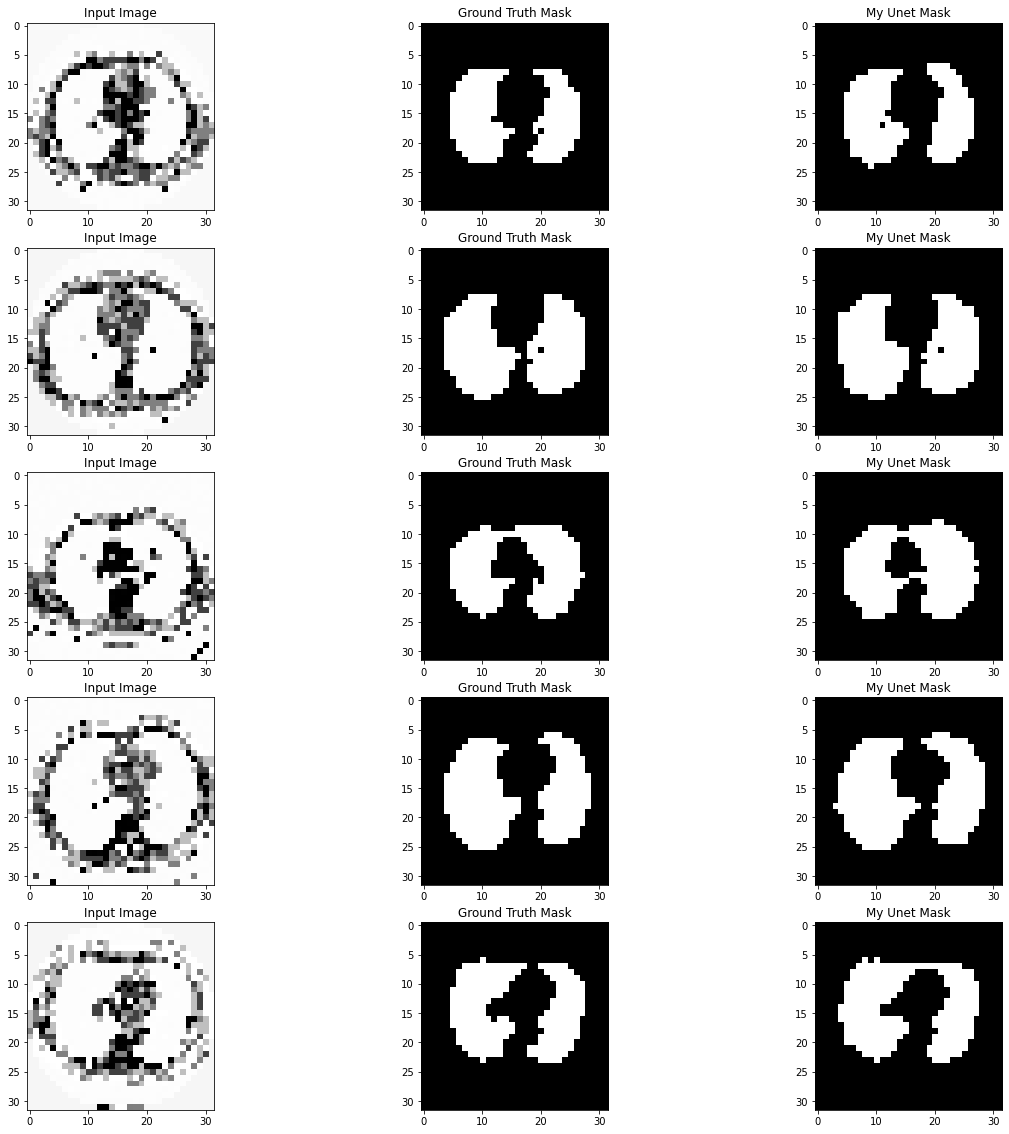

In [ ]:
list_of_index = np.random.choice(list(range(20)),size=5,replace=False)

images = []
masks = []
outputs = []

for i, data in enumerate(val_dataloader):
  for index in list_of_index:
    # get output of image and
    output = model(torch.unsqueeze(data['image'][index,:,:,:],0).float().to(device))
    output = torch.round(F.sigmoid(output))

    image = data['image'][index,:,:,:].squeeze()
    mask = data['mask'][index,:,:,:].squeeze()
    outputs.append(output.cpu().squeeze().detach().numpy())
    images.append(image)
    masks.append(mask)
  break

plt.figure(figsize=(20,20))

plt.subplot(5,3,1)
plt.imshow(images[0],cmap='gray')
plt.title('Input Image')
plt.subplot(5,3,2)
plt.imshow(masks[0],cmap='gray')
plt.title('Ground Truth Mask')
plt.subplot(5,3,3)
plt.imshow(outputs[0],cmap='gray')
plt.title('My Unet Mask')

plt.subplot(5,3,4)
plt.imshow(images[1],cmap='gray')
plt.title('Input Image')
plt.subplot(5,3,5)
plt.imshow(masks[1],cmap='gray')
plt.title('Ground Truth Mask')
plt.subplot(5,3,6)
plt.imshow(outputs[1],cmap='gray')
plt.title('My Unet Mask')


plt.subplot(5,3,7)
plt.imshow(images[2],cmap='gray')
plt.title('Input Image')
plt.subplot(5,3,8)
plt.imshow(masks[2],cmap='gray')
plt.title('Ground Truth Mask')
plt.subplot(5,3,9)
plt.imshow(outputs[2],cmap='gray')
plt.title('My Unet Mask')


plt.subplot(5,3,10)
plt.imshow(images[3],cmap='gray')
plt.title('Input Image')
plt.subplot(5,3,11)
plt.imshow(masks[3],cmap='gray')
plt.title('Ground Truth Mask')
plt.subplot(5,3,12)
plt.imshow(outputs[3],cmap='gray')
plt.title('My Unet Mask')


plt.subplot(5,3,13)
plt.imshow(images[4],cmap='gray')
plt.title('Input Image')
plt.subplot(5,3,14)
plt.imshow(masks[4],cmap='gray')
plt.title('Ground Truth Mask')
plt.subplot(5,3,15)
plt.imshow(outputs[4],cmap='gray')
plt.title('My Unet Mask')


## Improve U-Net

improve U-Net and compare accuracy and networks outputs with previous parts.

In [ ]:

class Up(nn.Module):
    def __init__(self, channel_in, channel_out):
        super(Up, self).__init__()
        self.conv_1 = nn.Conv2d(channel_in,channel_out,3,padding=1)
        self.relu_1 = nn.ReLU()
        self.conv_2 = nn.Conv2d(channel_out,channel_out,3,padding=1)
        self.relu_2 = nn.ReLU()
        self.deconv = nn.ConvTranspose2d(channel_out,int(channel_out / 2),2,stride=2)

    def forward(self, x1, x2):
        x = torch.cat((x1,x2),dim=1)
        x = self.conv_1(x)
        x = self.relu_1(x)
        x = self.conv_2(x)
        x = self.relu_2(x)
        x = self.deconv(x)

        return x        



class Down(nn.Module):
    def __init__(self, channel_in, channel_out):
        super(Down, self).__init__()
        self.conv_1 = nn.Conv2d(channel_in,channel_out,3,padding=1)
        self.relu_1 = nn.ReLU()
        self.conv_2 = nn.Conv2d(channel_out,channel_out,3,padding=1)
        self.relu_2 = nn.ReLU()
    
    def forward(self, x):
        x = self.conv_1(x)
        x = self.relu_1(x)
        x = self.conv_2(x)
        x = self.relu_2(x)
        return x

class Better_UNet(nn.Module):
    def __init__(self, channel_in, classes):
        super(Better_UNet, self).__init__()
        self.maxpool_2_2 = nn.MaxPool2d(kernel_size=2,stride=2)
        self.conv_down_1 = Down(1,64)
        self.conv_down_2 = Down(64,128)
        self.conv_down_3 = Down(128,512)
        self.identity_conv_1 = nn.Conv2d(512,1024,1)
        self.conv_up_0 = nn.ConvTranspose2d(1024,512,2,stride=2)
        self.conv_up_1 = Up(1024,256)
        self.conv_up_2 = Up(256,64)
        self.last_conv = nn.Conv2d(96,64,3,padding=1)
        self.identity_conv_2 = nn.Conv2d(64,classes,1)
        
    def forward(self, x):
        
        # ENCODER
        x1 = self.conv_down_1(x) # 32 * 32
        x2 = self.maxpool_2_2(x1)
        x3 = self.conv_down_2(x2) # 16 * 16
        x4 = self.maxpool_2_2(x3)
        x5 = self.conv_down_3(x4) # 8 * 8
        x6 = self.maxpool_2_2(x5) 
        x7 = self.identity_conv_1(x6) # 4 * 4

        # DECODER
        x8 = self.conv_up_0(x7)
        x9 = self.conv_up_1(x8,x5)
        x10 = self.conv_up_2(x9,x3)
        x11 = torch.cat((x10,x1),dim=1)
        x12 = self.last_conv(x11)
        x13 = self.identity_conv_2(x12)

        return x13


    
def weights_init(m):
    if isinstance(m, nn.Conv2d):
        init.xavier_uniform(m.weight, gain=numpy.sqrt(2.0))
        init.constant(m.bias, 0.1)




In [ ]:
device = 'cuda:0'
freq = 4
model = Better_UNet(channel_in=1,classes=1).to(device)



optimizer = optim.Adam(model.parameters(),lr=.001,weight_decay=7e-4)
schedular = optim.lr_scheduler.ReduceLROnPlateau(optimizer,factor=.99,patience=8)
criterion = nn.BCEWithLogitsLoss() 

def train(model, epoch):
    epoch_loss = 0
    for batch_idx, data in enumerate(train_dataloader):
        
        train_precision_list = []
        optimizer.zero_grad()

        inputs = data['image'].float().to(device)
        labels = data['mask'].float().to(device)

        outputs = model(inputs).to(device)
        loss = criterion(outputs,labels)

        train_precision = IOU(outputs,labels)
        train_precision_list.append(train_precision)

        loss.backward()

        epoch_loss += loss.item()

        optimizer.step()
        schedular.step(loss.item())
        if (batch_idx + 1) % freq == 0:

          print(f'********************** Epoch {epoch} **********************')
          print(f'precision On Train Set Is {torch.mean(torch.Tensor(train_precision_list))}')
          print(f'Loss On Train Set Is {epoch_loss}')

def test(model):
    test_loss = 0
    test_precision_list = []
    for data in val_dataloader:
        with torch.no_grad():
          inputs = data['image'].float().to(device)
          labels = data['mask'].float().to(device)

          outputs = model(inputs).to(device)
          loss = criterion(outputs,labels)
          test_loss += loss.item()
          test_precision = IOU(outputs,labels)
          test_precision_list.append(test_precision)

    print(f'precision On Validation Set Is {torch.mean(torch.Tensor(test_precision_list))}')
    print(f'Loss On Validation Set Is {test_loss}')
    print('###############################################')




Num_of_eopchs = 100

for epoch in range(1, Num_of_eopchs):
    train(model, epoch)
    test(model)


********************** Epoch 1 **********************
precision On Train Set Is 0.3707934617996216
Loss On Train Set Is 54.47451663017273
precision On Validation Set Is 0.37782591581344604
Loss On Validation Set Is 12.116789817810059
###############################################
********************** Epoch 2 **********************
precision On Train Set Is 0.37311285734176636
Loss On Train Set Is 7.71122545003891
precision On Validation Set Is 0.27474525570869446
Loss On Validation Set Is 3.4995089769363403
###############################################
********************** Epoch 3 **********************
precision On Train Set Is 0.40487149357795715
Loss On Train Set Is 2.7566365003585815
precision On Validation Set Is 0.4511979818344116
Loss On Validation Set Is 2.207943379878998
###############################################
********************** Epoch 4 **********************
precision On Train Set Is 0.4630309045314789
Loss On Train Set Is 2.1293296217918396
precision On Va

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fec20833200>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fec20833200>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

********************** Epoch 66 **********************
precision On Train Set Is 0.940044105052948
Loss On Train Set Is 0.2771117575466633
precision On Validation Set Is 0.941367506980896
Loss On Validation Set Is 0.28106820955872536
###############################################
********************** Epoch 67 **********************
precision On Train Set Is 0.9465432167053223
Loss On Train Set Is 0.2682306468486786
precision On Validation Set Is 0.9383658170700073
Loss On Validation Set Is 0.2872456833720207
###############################################
********************** Epoch 68 **********************
precision On Train Set Is 0.946271538734436
Loss On Train Set Is 0.2574579641222954
precision On Validation Set Is 0.9407797455787659
Loss On Validation Set Is 0.2821209691464901
###############################################
********************** Epoch 69 **********************
precision On Train Set Is 0.9253367781639099
Loss On Train Set Is 0.2640921398997307
precision On 

## here are things i did to imrove precision by 0.9 %
  1. reduced conv counts to 2 on last layer
  2. set weight-decay = 1e-7
  3. used a lr schedular with patience = 8 and factor=.99

at last my best precision reached 94.35 % on epoch 89
